# Examples using the [Actflow Toolbox](https://colelab.github.io/ActflowToolbox/) with Human Connectome Project data

See the [Actflow Toolbox](https://colelab.github.io/ActflowToolbox/) for more information

Run the code yourself here: [https://github.com/ColeLab/ActflowToolbox/blob/master/examples/HCP_example.ipynb](https://github.com/ColeLab/ActflowToolbox/blob/master/examples/HCP_example.ipynb)

# Activity flow mapping

## This toolbox implements functions that support activity flow mapping, such as functional connectivity estimation, activity flow modeling, and activity flow model evaluation

## Activity flow mapping has two basic steps:

### 1) Activity flow modeling: Simulating the flow (movement) of activity between neural populations, using empirical data to estimate activity levels and routes of flow (connectivity).

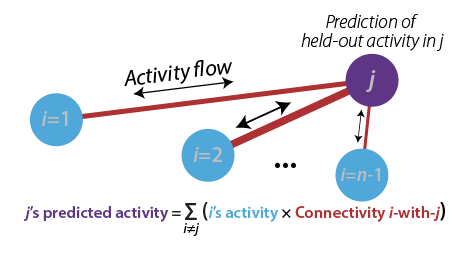

### 2) Testing prediction accuracy: The predicted brain activity pattern is compared to the actual recorded activity, providing evidence for or against the activity flow model used to make the predictions. Predictions of multiple models can be compared to quantify model validity.

### See for more info: [Cole, Michael W, Takuya Ito, Danielle S Bassett, and Douglas H Schultz. (2016). “Activity Flow over Resting-State Networks Shapes Cognitive Task Activations.” Nature Neuroscience 19 (12): 1718–26. doi:10.1038/nn.4406.](http://rdcu.be/kOJq)

# Cole-Anticevic Network Partition
### Used for this example: https://github.com/ColeLab/ColeAnticevicNetPartition
### Citation: [Ji JL*, Spronk M*, Kulkarni K, Repovs G, Anticevic A**, Cole MW** (2019). "Mapping the human brain's cortical-subcortical functional network organization". NeuroImage. 185:35–57. doi:10.1016/j.neuroimage.2018.10.006 (* = equal contribution; ** = senior authors)](https://www.colelab.org/pubs/2018_NeuroImage_JiSpronk.pdf)
![Cole-Anticevic Network Partition](CABNP_cortex.png)

In [1]:
#Import packages and set variables

import numpy as np
import h5py
import pkg_resources
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams.update({'font.size': 16})
plt.rcParams['image.aspect'] = 'equal'
plt.rcParams['image.cmap'] = 'seismic'

import ActflowToolbox as actflow

actflow_example_dir = pkg_resources.resource_filename('ActflowToolbox.examples', 'HCP_example_data/')

networkpartition_dir = pkg_resources.resource_filename('ActflowToolbox.dependencies', 'ColeAnticevicNetPartition/')
networkdef = np.loadtxt(networkpartition_dir + '/cortex_parcel_network_assignments.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]
orderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)


subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832']
numsubjs=np.shape(subjNums)[0]
numnodes=360
numtimepoints=1195

taskConditions = ['EMOTION:fear','EMOTION:neut','GAMBLING:win','GAMBLING:loss','LANGUAGE:story','LANGUAGE:math',
                  'MOTOR:cue','MOTOR:lf','MOTOR:rf','MOTOR:lh','MOTOR:rh','MOTOR:t','REASONING:rel',
                  'REASONING:match','SOCIAL:mental','SOCIAL:rnd','WM 0bk:body','WM 0bk:faces','WM 0bk:places',
                  'WM 0bk:tools','WM 2bk:body','WM 2bk:faces','WM 2bk:places','WM 2bk:tools']


# Load data

In [2]:
#Load data
#Data from: https://www.humanconnectome.org/study/hcp-young-adult
#Preprocessed as described here: https://doi.org/10.1101/560730

#Load resting-state fMRI data; 30 HCP subjects, one run of resting-state fMRI each
restdata=np.zeros((numnodes,numtimepoints,numsubjs))
scount = 0
for subj in subjNums:
    file_path=actflow_example_dir + 'HCP_example_restrun1_subj' + subj + '_data' + '.h5'
    h5f = h5py.File(file_path,'r')
    dataid = 'restdata'
    restdata[:,:,scount] = h5f[dataid][:]
    h5f.close()
    scount += 1

#Load task GLM activations; 30 HCP subjects, 24 task conditions
file_path=actflow_example_dir + 'HCP_example_taskactivations_data' + '.h5'
h5f = h5py.File(file_path,'r')
dataid = 'taskbeta'
activations_bycond = h5f[dataid][:]
h5f.close()


# Activity flow mapping with Pearson correlation FC

## The current field-standard FC measure (but with clear issues for causal interpretation)

In [12]:
%%time
#Run activity flow mapping with Pearson correlation FC
restFC_corr=np.zeros((numnodes,numnodes,numsubjs))
scount=0
for subj in subjNums:
    restFC_corr[:,:,scount]=actflow.connectivity_estimation.corrcoefconn(restdata[:,:,scount])
    scount += 1
print("==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr)


==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.58, t-value vs. 0: 50.09, p-value vs. 0: 1.0236377961735527e-29
 
Mean % variance explained (R^2 score, coeff. of determination) = -747.11
 
Mean MAE (mean absolute error) = 313.77
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scik

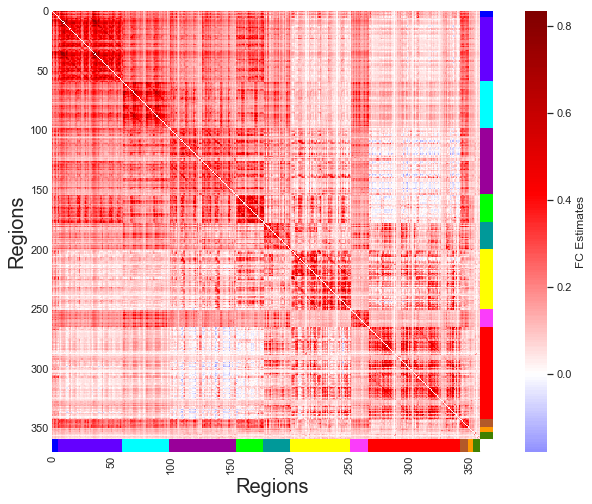

In [13]:
#Visualize FC matrix
fcmat=np.mean(restFC_corr[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

[Text(40.5, 0.5, 'Regions')]

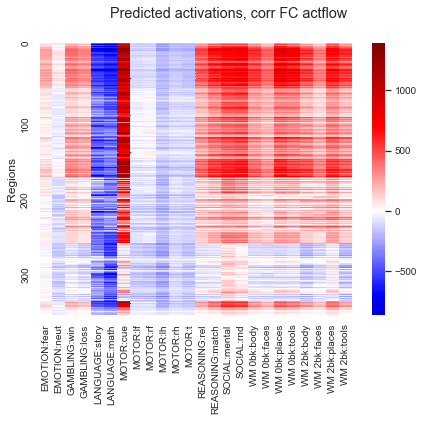

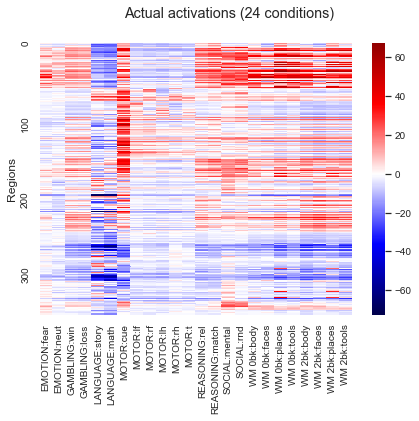

In [14]:
#Visualize predicted and actual activation patterns

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Predicted activations, corr FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -163.9024780174406
Max value:  557.5773143192291


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -20.209393092277782
Max value:  33.18593086232514


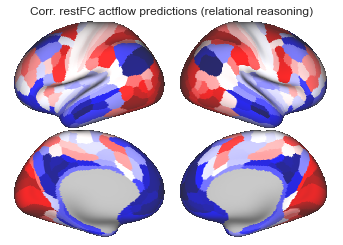

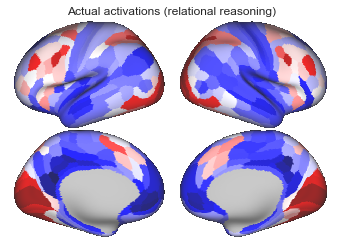

In [15]:
#Plotting brain surface images in-line, FC-based predictions 

condNum=12 #condition 9 = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Corr. restFC actflow predictions (relational reasoning)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (relational reasoning)')
plt.imshow(img)



# Activity flow mapping with combinedFC

## A more causally valid version of correlation (Pearson correlation + partial correlation)

<img src="Figure01_Proof1.png" width="400" align="left"/>

### See for more info: [Sanchez-Romero, Ruben, and Michael W. Cole. (2020). “Combining Multiple Functional Connectivity Methods to Improve Causal Inferences.” Journal of Cognitive Neuroscience, 1–15. doi:10.1162/jocn_a_01580.](https://www.colelab.org/pubs/2020_SanchezCole.pdf)

### Note: This is the current recommended best practice for activity flow mapping

In [16]:
%%time
#Run activity flow mapping with combinedFC
restFC_combFC=np.zeros((numnodes,numnodes,numsubjs))
scount=0
for subj in subjNums:
    restFC_combFC[:,:,scount]=actflow.connectivity_estimation.combinedFC(restdata[:,:,scount])
    scount += 1
    
print("==Activity flow mapping results, combinedFC-based resting-state FC, 24 task conditions==")
actflowOutput_restFCcombFC_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_combFC)


==Activity flow mapping results, combinedFC-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.70, t-value vs. 0: 72.53, p-value vs. 0: 2.4170841995108216e-34
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.46
 
Mean MAE (mean absolute error) = 8.56
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-lea

### Next, use multiple-regression FC to adjust weights to better optimize for prediction

In [17]:
%%time
#Run multiple-regression FC using only the combinedFC-validated connections
#This adjusts the weights to better optimize for prediction, rather than using abstract r-values
#(see Cole, Michael W, Takuya Ito, Danielle S Bassett, and Douglas H Schultz. (2016). “Activity Flow over Resting-State Networks Shapes Cognitive Task Activations.” Nature Neuroscience 19 (12): 1718–26. doi:10.1038/nn.4406.)
restFC_mregCombFC=np.zeros((numnodes,numnodes,numsubjs))
scount=0
for subj in subjNums:
    restFC_mregCombFC[:,:,scount]=actflow.connectivity_estimation.multregconn(restdata[:,:,scount],conn_mask=(restFC_combFC[:,:,scount]!=0))
    scount += 1

print("==Activity flow mapping results, combinedFC+multreg-based resting-state FC, 24 task conditions==")
actflowOutput_restFCcombFCmultreg_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mregCombFC)


==Activity flow mapping results, combinedFC+multreg-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.81, t-value vs. 0: 64.44, p-value vs. 0: 7.308483937481038e-33
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.65
 
Mean MAE (mean absolute error) = 6.83
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://sci

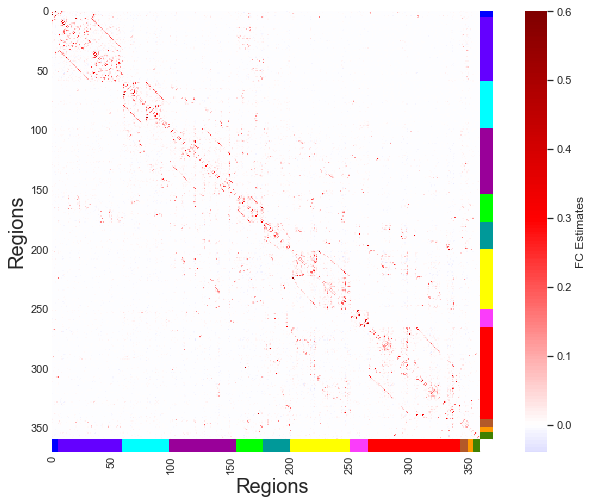

In [18]:
#Visualize FC matrix
fcmat=np.mean(restFC_mregCombFC[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

[Text(40.5, 0.5, 'Regions')]

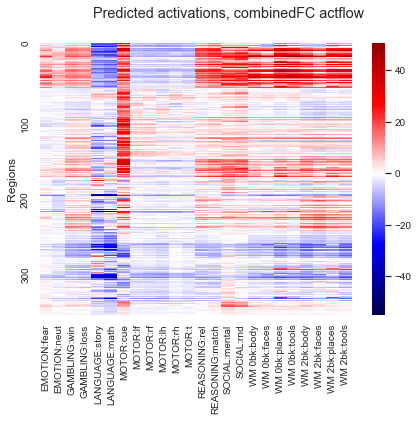

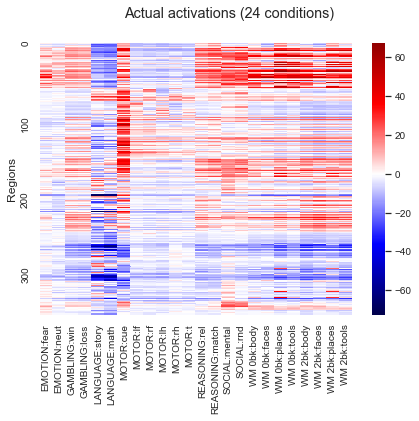

In [21]:
#Visualize predicted and actual activation patterns

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCcombFCmultreg_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Predicted activations, combinedFC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -12.605234785397633
Max value:  28.306067880714533


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -20.209393092277782
Max value:  33.18593086232514


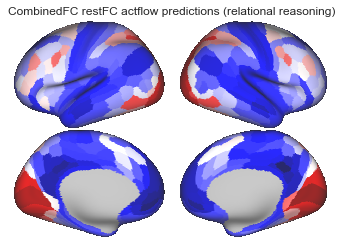

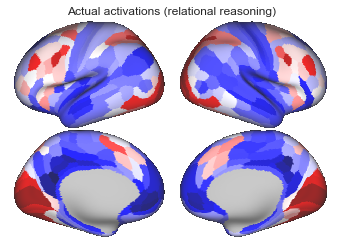

In [22]:
#Plotting brain surface images in-line, FC-based predictions 

condNum=12 #condition 9 = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCcombFCmultreg_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('CombinedFC restFC actflow predictions (relational reasoning)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (relational reasoning)')
plt.imshow(img)



# Activity flow mapping with multiple-regression FC

### See for more info: Cole, Michael W, Takuya Ito, Danielle S Bassett, and Douglas H Schultz. (2016). “Activity Flow over Resting-State Networks Shapes Cognitive Task Activations.” Nature Neuroscience 19 (12): 1718–26. doi:10.1038/nn.4406.

In [7]:
%%time
#Run activity flow mapping with ten subjects (to reduce processing time)

#Calculate multiple-regression FC
restFC_mreg=np.zeros((numnodes,numnodes,numsubjs))
for scount in np.arange(numsubjs):
    restFC_mreg[:,:,scount]=actflow.connectivity_estimation.multregconn(restdata[:,:,scount])


CPU times: user 2h 48min 27s, sys: 7min 13s, total: 2h 55min 40s
Wall time: 9min 5s


In [8]:
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==")
actflowOutput_restFCMReg_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg)

==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.78, t-value vs. 0: 62.27, p-value vs. 0: 1.9635597302245892e-32
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.57
 
Mean MAE (mean absolute error) = 7.54
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://s

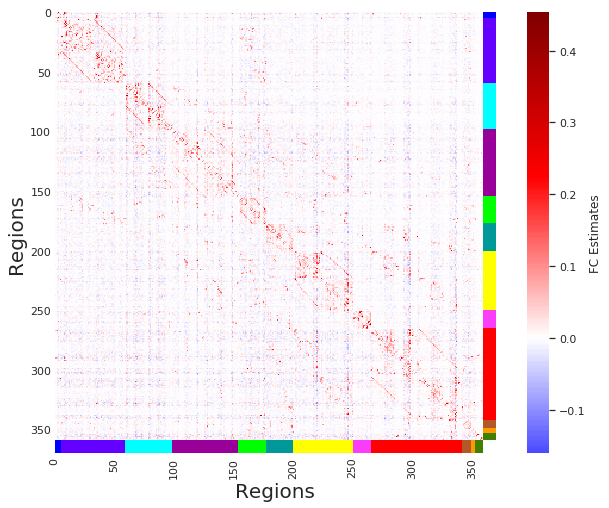

In [9]:
#Visualize multreg FC matrix
fcmat=np.mean(restFC_mreg[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

[Text(39.5, 0.5, 'Regions')]

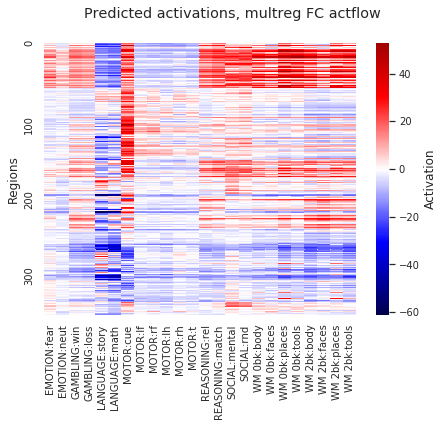

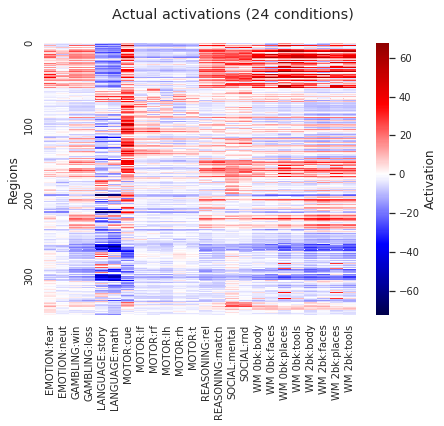

In [10]:
#Visualize predicted and actual activation patterns, with multiple-regression FC
plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,cbar_kws={'label': 'Activation'},yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Predicted activations, multreg FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
#Activation (z-score)
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,cbar_kws={'label': 'Activation'},yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -16.59970533540053
Max value:  26.27911656833697
Min value:  -20.209393092277782
Max value:  33.18593086232514


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


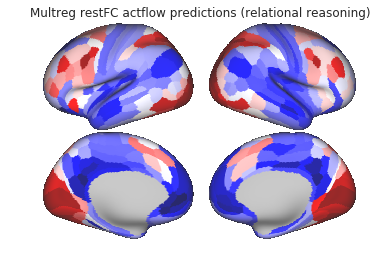

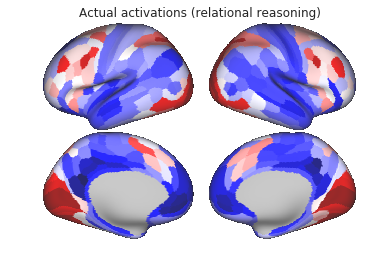

In [11]:
#Plotting brain surface images in-line, FC-based predictions 

condNum=12 #condition 9 = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Multreg restFC actflow predictions (relational reasoning)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (relational reasoning)')
plt.imshow(img)



# Comparing prediction accuracy of multiple-regression FC to Pearson correlation FC

In [12]:
print("===Compare resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===")
model_compare_RestMultRegFCVsRestCorrFC_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCCorr_bycond['actVect_actual_group'][:,:,0:10], model1_actvect=actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'][:,:,0:10], full_report=False, print_report=True)


===Compare resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 10 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.78
Model2 mean Pearson r=0.59
R-value difference = 0.20
Model1 vs. Model2 T-value: 12.81, p-value: 4.4133474737407104e-07
 
Model1 mean % predicted variance explained R^2=0.58
Model2 mean % predicted variance explained R^2=-595.00
R^2 difference = 595.57
 
Model1 mean MAE = 7.08
Model2 mean MAE = 277.10
Model1 vs. Model2 mean MAE difference = -270.02
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R

## Testing generalization across task conditions

In [13]:
print("===Compare TASK CONDITIONS SEPARATE, resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===")
model_compare_RestMultRegFCVsRestCorrFC_Actflow_nodewise = actflow.model_compare(target_actvect=actflowOutput_restFCCorr_bycond['actVect_actual_group'][:,:,0:10], model1_actvect=actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'][:,:,0:10], comparison_type='nodewise_compthenavg', full_report=False, print_report=True)


===Compare TASK CONDITIONS SEPARATE, resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Node-wise (spatial) correlations between predicted and actual activation patterns (calculated for each condition separetely):==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each correlation based on N nodes: 360, p-values based on N subjects (cross-subject variance in correlations): 10
Model1 mean Pearson r=0.74
Model2 mean Pearson r=0.56
R-value difference = 0.18
Model1 vs. Model2 T-value: 21.83, p-value: 4.185118497632039e-09
By task condition:
Condition 1: Model 1 r=0.62, Model 2 r=0.52, Model 1 vs. 2 R-value difference =0.10, t-value Model1 vs. Model2: 6.48, p-value vs. 0: 0.00011350821684287335
Condition 2: Model 1 r=0.62, Model 2 r=0.49, Model 1 vs. 2 R-value difference

### Characterizing predictions using multiple-regression FC

[Text(0.5, 0, 'Task condition')]

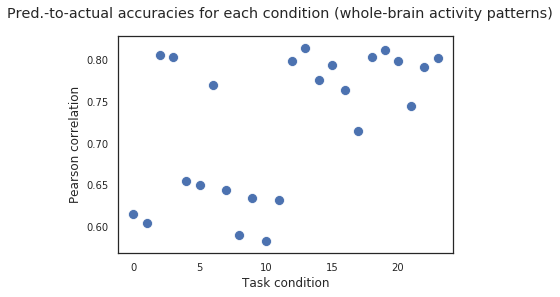

In [14]:
ax = sns.scatterplot(np.arange(24),np.mean(model_compare_RestMultRegFCVsRestCorrFC_Actflow_nodewise['corr_nodewise_compthenavg_bycond'],axis=1), s=100)
ax.figure.suptitle('Pred.-to-actual accuracies for each condition (whole-brain activity patterns)')
ax.set(ylabel='Pearson correlation')
ax.set(xlabel='Task condition')

[Text(0.5, 0, 'Task condition')]

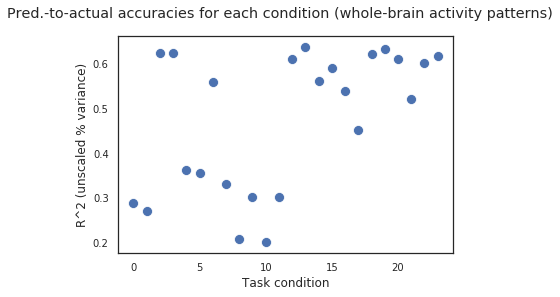

In [15]:
ax = sns.scatterplot(np.arange(24),np.mean(model_compare_RestMultRegFCVsRestCorrFC_Actflow_nodewise['R2_nodewise_compthenavg_bycond'],axis=1), s=100)
ax.figure.suptitle('Pred.-to-actual accuracies for each condition (whole-brain activity patterns)')
ax.set(ylabel='R^2 (unscaled % variance)')
ax.set(xlabel='Task condition')

## Testing generalization across regions

In [16]:
print("===Compare REGIONS SEPARATE (24-condition response profiles), resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===")
model_compare_RestMultRegFCVsRestCorrFC_Actflow_condwise = actflow.model_compare(target_actvect=actflowOutput_restFCCorr_bycond['actVect_actual_group'][:,:,0:10], model1_actvect=actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'][:,:,0:10], comparison_type='conditionwise_compthenavg', full_report=False, print_report=True)


===Compare REGIONS SEPARATE (24-condition response profiles), resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Condition-wise comparisons between predicted and actual activation patterns (calculated for each node separetely):==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each correlation based on N conditions: 24, p-values based on N subjects (cross-subject variance in correlations): 10
 
Model1 mean Pearson r=0.81
Model2 mean Pearson r=0.62
R-value difference = 0.19
Model1 vs. Model2 T-value: 12.46, p-value: 5.572065132326254e-07
 
Model1 mean % predicted variance explained R^2=0.09
Model2 mean % predicted variance explained R^2=-1450.42
R^2 difference = 1450.51
 
Model1 mean MAE = 7.08
Model2 mean MAE = 277.10
Model1 vs. Model2 mean MAE difference = -270.02

### Characterizing predictions using multiple-regression FC

[Text(0.5, 0, 'Region')]

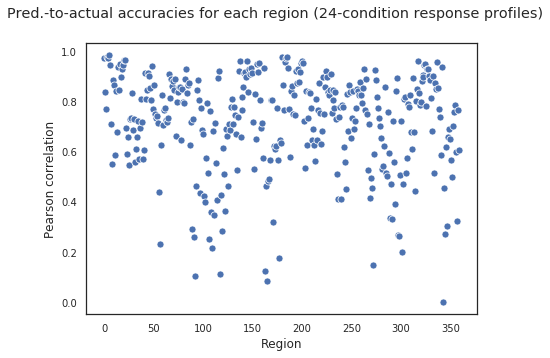

In [17]:
plt.figure(figsize=[7,5])
ax = sns.scatterplot(np.arange(360),np.mean(model_compare_RestMultRegFCVsRestCorrFC_Actflow_condwise['corr_conditionwise_compthenavg_bynode'],axis=1), s=50)
ax.figure.suptitle('Pred.-to-actual accuracies for each region (24-condition response profiles)')
ax.set(ylabel='Pearson correlation')
ax.set(xlabel='Region')

[Text(0.5, 0, 'Region')]

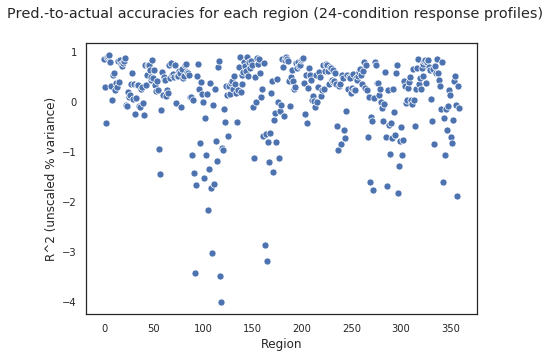

In [18]:
plt.figure(figsize=[7,5])
ax = sns.scatterplot(np.arange(360),np.mean(model_compare_RestMultRegFCVsRestCorrFC_Actflow_condwise['R2_conditionwise_compthenavg_bynode'],axis=1), s=50)
ax.figure.suptitle('Pred.-to-actual accuracies for each region (24-condition response profiles)')
ax.set(ylabel='R^2 (unscaled % variance)')
ax.set(xlabel='Region')

# Testing impact of fMRI smoothness resulting in potential prediction circularity

It is known that fMRI has some inherent spatial smoothness that blurs data spatially due to local vasculature. This smoothness is thought to extend somewhere between 2 mm and 5 mm (Malonek and Grinvald 1996; Logothetis and Wandell 2004). In theory this could result in some circularity to the actflow predictions (e.g., the target region's activity blurs into a source region's activity). The code below demonstrates an approach to remove any region within 10 mm of each to-be-predicted target region, removing any potential circularity due to vascular spatial smoothness. Note that there was only a small reduction in prediction accuracy in the results below (likely due to having fewer predictors), suggesting spatial smoothness results in minor (if any) prediction circularity.

In [19]:
#Load dictionary listing which parcels to exclude for each target
networkdefdir = pkg_resources.resource_filename('ActflowToolbox', 'network_definitions/')
inputfilename = networkdefdir+'parcels_to_remove_indices_cortexonly_data.h5'
h5f = h5py.File(inputfilename,'r')
parcels_to_remove={}
for parcelInt in range(numnodes):
    outname1 = 'parcels_to_remove_indices'+'/'+str(parcelInt)
    parcels_to_remove[parcelInt] = h5f[outname1][:].copy()
h5f.close()

In [20]:
%%time

#Calculate multiple-regression FC, excluding parcels within 10 mm of each target parcel
restFC_mreg_parcelnoncirc=np.zeros((numnodes,numnodes,numsubjs))
for scount in np.arange(numsubjs):
    restFC_mreg_parcelnoncirc[:,:,scount]=actflow.connectivity_estimation.multregconn(restdata[:,:,scount], parcelstoexclude_bytarget=parcels_to_remove)

CPU times: user 2h 14min 31s, sys: 5min 15s, total: 2h 19min 47s
Wall time: 6min 59s


In [21]:
print("==Activity flow mapping results, multiple-regression-based resting-state FC (parcel non-circular), 24 task conditions==")
actflowOutput_restFCMReg_parcelnoncirc_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_parcelnoncirc)


==Activity flow mapping results, multiple-regression-based resting-state FC (parcel non-circular), 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.73, t-value vs. 0: 54.55, p-value vs. 0: 8.804966610436179e-31
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.50
 
Mean MAE (mean absolute error) = 8.19
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to posi

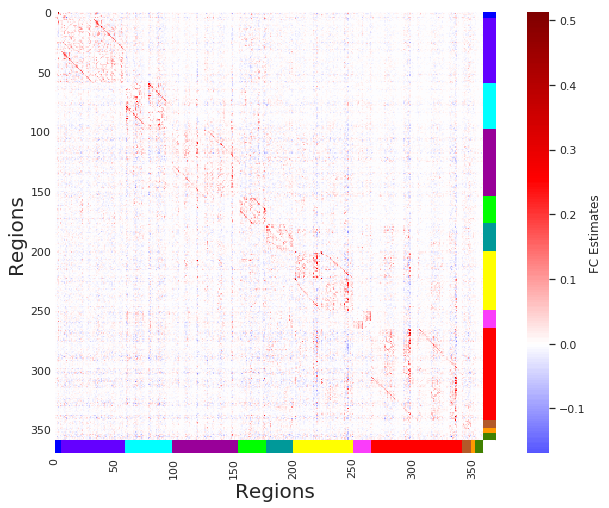

In [22]:
#Visualize multreg noncircular FC matrix
fcmat=np.mean(restFC_mreg_parcelnoncirc[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)